## Notebook for Figure 1 and related content: Cell types, QC, Experimental Distributions
### Author: J. Camunas-Soler
### Last Updated: Feb. 2020

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
%matplotlib inline
from singlet.dataset import Dataset
from singlet import SampleSheet, CountsTable
import matplotlib.patches as mpatches

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


In [3]:
%run ./../functions/helper_functions.py

#### Load Data and definitions

In [4]:
dict_phenotype_norm = {'CellSize_pF': 'Cell size',
                   'NormalizedTotalCapacitance_fF/pF': 'Total Exocitosis',
                   'NormalizedFirstDepolarizationCapacitance_fF/pF': 'Early exocytosis',
                   'NormalizedLateDepolarizationCapacitance': 'Late exocytosis',
                 'CalciumIntegralNormalizedtoCellSize_pC/pF': 'Ca2+ entry',
                   'CapacitanceNormalizedtoCalcium_fF/pC': 'Exocytosis norm Ca2+',
                   'NormalizedEarlyPeakCalciumCurrentAmplitude_pA/pF': 'Early Ca2+ current',
                 'NormalizedLateCalciumCurrentAmplitude_pA/pF': 'Late Ca2+ current',
                   'NormalizedLateCalciumChannelConductance_pS/pF' : 'Late Ca2+ Conductance',
                   'ReversalPotentialbyramp_mV': 'Reversal potential',
                   'NormalizedPeakSodiumCurrentAmplitude_pA/pF': 'Peak Na+ current',
                  'NormalizedSodiumChannelConductance_pS/pF': 'Na+ conductance'}

phenotype_norm = ['Cell size', 'Total Exocitosis','Early exocytosis','Late exocytosis',
                          'Ca2+ entry','Exocytosis norm Ca2+', 'Early Ca2+ current','Late Ca2+ current',
                          'Late Ca2+ Conductance','Reversal potential','Peak Na+ current','Na+ conductance']

In [5]:
root_folder = './../data/'
analysis_folder = './../analysis/'
fig_folder = './../figures/fig1_suppfig1_2/'

In [6]:
#Load and reformat patch-seq dataset
filename =  root_folder + 'patchclamp_wcryo_human.counts.tab'
metadata = root_folder + 'patchclamp_wcryo_human.metadata.tab'

test = pd.read_csv(filename,sep='\t')
annotation = pd.read_csv(metadata,'\t')
annotation = annotation.drop(['cell_type'],axis=1)

annotation['DiabetesStatus'].replace({'heathy': 'healthy'}, inplace=True)
annotation['DiabetesStatus'].replace({'elevated HbA1c': 'T2D'}, inplace=True)
#add cell type information already computed
ct_all = pd.read_csv(analysis_folder + 'cell_typing_merged.csv', sep='\t', index_col=0, names=['cell_type'])
ct_FACS = pd.read_csv(analysis_folder +'cell_typing_FACS_endocrine.csv', sep='\t', index_col=0, names=['cell_type'])
ct_all = pd.concat([ct_all,ct_FACS])
annotation = annotation.join(ct_all['cell_type'], on='name')

annotation.rename(columns=dict_phenotype_norm, inplace=True)
#remove commas from data ephys
annotation[phenotype_norm] = annotation[phenotype_norm].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))
annotation[phenotype_norm] = annotation[phenotype_norm].astype(float)

#remove genes not seen in 5 cells or having 10 counts total
test= filter_genes_pp(test, min_cells=5, min_counts=10)
#create dataset
ds = Dataset(counts_table=CountsTable(test),samplesheet=SampleSheet(annotation))
#remove nans in glucse
ds.samplesheet = ds.samplesheet[~ds.samplesheet[['Glucose_mM']].isnull().values]
#save unnormalized table
ds_pclamp_raw = ds.copy()
# Get data and normalize gene expression to combine cell size plot and marker genes
ds_norm = ds.copy()
ds_norm.counts = ds_norm.counts.normalize()
ds_norm.counts.pseudocount = 1
ds_norm.counts = ds_norm.counts.log(base=2)
ds_norm.counts.pseudocount = 1
ds_norm_pclamp = ds_norm.copy()

filter_condition = {'Cryopreserved': ['Yes']}
ds_t1d = filter_samplesheet(ds_norm, filter_dict= filter_condition)

filter_condition = {'Cryopreserved': ['No']}
ds_pclamp = filter_samplesheet(ds_norm, filter_dict= filter_condition)

In [7]:
cols = ['project',
 'experiment',
 'sequencingInstrument',
 'sequencingRun',
 'sequencingDate',
 'species',
 'nCells',
 'ERCC_factor',
 'plate',
 'STAR_input_reads',
 'STAR_percent_uniquely_mapped',
 'STAR_percent_multiple_loci',
 'STAR_percent_too_many_loci',
 'STAR_percent_unmapped_too_many_mismatches',
 'STAR_percent_unmapped_too_short',
 'Ca2+ entry',
 'CalciumIntegralatFirstDepolarization_pC',
 'Exocytosis norm Ca2+',
 'Cell size',
 'CellTypeEstimatePatching',
 'EarlyPeakCalciumCurrentAmplitudeat-10mV_pA',
 'FirstDepolarizationCapacitance_fF',
 'Glucose_mM',
 'HalfInactivationCaCurrent_mV',
 'HalfInactivationSodiumCurrent_mV',
 'Hyperpolarizationactivatedcurrent at-140mV_pA',
 'LateCalciumChannelConductance_pS',
 'LateCalciumCurrentAmplitudeat-10mV_pA',
 'LateDepolarizationCapacitance',
 'Early Ca2+ current',
 'Early exocytosis',
 'NormalizedHyperpolarizationactivatedcurrent at-140mV_pA/pF',
 'Late Ca2+ Conductance',
 'Late Ca2+ current',
 'Late exocytosis',
 'Peak Na+ current',
 'Na+ conductance',
 'Total Exocitosis',
 'PeakSodiumCurrentAmplitudeat0mV_pA',
 'ReversalPotentialbyCacurrents_mV',
 'Reversal potential',
 'SodiumChannelConductance_pS',
 'SolutioninDish',
 'TimefromDispersion_days',
 'TimeinDish_min',
 'TotalCapacitance_fF',
 'VoltageSodiumPeakCurrent_mV',
 'preincubation',
 'Wells',
 'ERCC',
 'Total_vol',
 'EmptyColumns',
 'Patched',
 'DonorID',
 'name',
 'Cryopreserved',
 'DiabetesStatus',
 'FACS sorted',
 'Days between hospitalization & procurement',
 'Isolation date',
 'Donating centre',
 'Age',
 'Sex',
 'Donation type',
 'Cause of death',
 'downtime (min)',
 'Blood type',
 'Height (m)',
 'weight (kg)',
 'Body mass index (BMI):',
 'Glycated hemoglobin (HbA1c)',
 'serum glucose measurements',
 'any known medical conditions',
 'Known prescription drug(s) taken by the donor',
 'Donor notes',
 'Cold ischemia time (h)',
 'Pancreas weight (g):',
 'Total IEQ',
 'IEQ per pancreas weight (IEQ/g):',
 'DNA content (ug):',
 'Insulin content (ug):',
 'Insulin content per IEQ (ng/IEQ):',
 'Insulin to DNA ratio',
 'Number of cells (millions)',
 '50-100 um',
 '101-150 um',
 '151-200 um',
 '201-250 um',
 '251-300 um',
 '301-350 um',
 '351-400 um',
 'culture time (day)',
 '10 mM to 1 mM stimulation index',
 '16.7 mM to 1 mM stimulation index',
 '16.7 mM to 2.8 mM stimulation index',
 'notes',
 'all_counts',
 'percent_mapped',
 'percent_ercc',
 'percent_multimapped',
 'percent_unmapped',
 'percent_nofeature',
 'percent_ambiguous',
 'percent_mito',
 'n_genes_1',
 'n_genes_3',
 'cell_type']

ds_pclamp.samplesheet[cols]

,project,experiment,sequencingInstrument,sequencingRun,sequencingDate,species,nCells,ERCC_factor,plate,STAR_input_reads,...,percent_mapped,percent_ercc,percent_multimapped,percent_unmapped,percent_nofeature,percent_ambiguous,percent_mito,n_genes_1,n_genes_3,cell_type
1001200601_A1,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,2436105,...,51.419245,2.415319,13.484122,18.499091,15.529209,1.068333,6.529397,5945,5437,alpha
1001200601_A10,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,3925408,...,35.524653,9.596419,10.666607,11.994615,41.041129,0.772996,2.319603,3466,3090,alpha
1001200601_A11,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,2761149,...,61.980226,3.553639,20.918881,6.598848,4.247459,6.254586,9.514389,6177,5814,beta
1001200601_A12,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,1286333,...,44.491486,3.489677,12.861288,16.889675,20.453497,5.304054,5.605052,5142,4711,beta
1001200601_A2,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,3377459,...,37.549069,5.693334,25.021861,11.740029,24.699477,0.988127,3.146508,4664,4259,alpha
1001200601_A3,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,1649894,...,48.327547,6.170190,14.333072,16.358672,20.091863,0.888847,6.184558,4012,3673,alpha
1001200601_A5,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,3079672,...,54.720094,6.524126,21.306139,11.321469,11.584046,1.068252,4.093084,4359,4008,alpha
1001200601_A6,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,3678683,...,54.961584,0.620119,4.848128,7.933632,28.707693,3.548962,3.712738,5595,5180,fail_qc
1001200601_A8,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,3364622,...,49.073709,6.860623,15.762588,8.633424,25.498367,1.031912,3.741655,4547,4232,alpha
1001200601_A9,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,2032817,...,35.837419,28.311146,4.005205,57.120736,2.037067,0.999573,0.023521,402,348,fail_qc


In [8]:
#### Load and reformat FACS dataset
filename =  root_folder + 'patchclamp_FACS_human.counts.tab'
metadata = root_folder + 'patchclamp_FACS_human.metadata.tab'
test = pd.read_csv(filename,sep='\t')
annotation = pd.read_csv(metadata,'\t')
annotation = annotation.drop(['cell_type'],axis=1)
annotation['DiabetesStatus'].replace({'heathy': 'healthy'}, inplace=True)
#add cell type information from scanpy
#add annotation of FACS cells
ct_all = pd.read_csv(analysis_folder+'cell_typing_merged.csv', sep='\t', index_col=0, names=['cell_type'])
ct_FACS = pd.read_csv(analysis_folder+'cell_typing_FACS_endocrine.csv', sep='\t', index_col=0, names=['cell_type'])
ct_all = pd.concat([ct_all,ct_FACS])

annotation = annotation.join(ct_all['cell_type'], on='name')
test= filter_genes_pp(test, min_cells=5, min_counts=10)
ds = Dataset(counts_table=CountsTable(test),samplesheet=SampleSheet(annotation))
# Get data and normalize gene expression to combine cell size plot and marker genes
ds_FACS_raw = ds.copy()
# Get data and normalize gene expression to combine cell size plot and marker genes
ds_FACS = ds.copy()
ds_FACS.counts = ds_FACS.counts.normalize()
ds_FACS.counts.pseudocount = 1
ds_FACS.counts = ds_FACS.counts.log(base=2)
ds_FACS.counts.pseudocount = 1

In [9]:
#### Load and reformat Segestolpe dataset
data_sand= pd.read_csv(root_folder+ 'Sandberg_pancreas_refseq_rpkms_counts_3514sc.txt', 
                   sep='\t',skiprows=1,header=None)
col_names = pd.read_csv(root_folder+'Sandberg_header.txt', 
                   sep='\t')
col_names = col_names.columns.drop('Unnamed: 0')
#Select raw counts from Sandberg
#Columns 1:3514 correspond to rpkm values 
#Columns 3515:7028 correspond to read counts
#Rows 1:26179 correspond to data for RefSeq genes
data_sand =data_sand.set_index(0).iloc[:,3515:7030]
data_sand.columns = col_names
data_sand = data_sand.iloc[0:26178,:]
mdata_sand = pd.read_csv(root_folder+'Sandberg_E-MTAB-5061.sdrf.txt', sep='\t')

mdata_sand = mdata_sand.set_index('Source Name')
dict_rename = {'Characteristics[body mass index]':'BMI',
 'Characteristics[individual]':'DonorID',
'Characteristics[cell type]':'cell_type', 'Characteristics[disease]':'DiabetesStatus',
       'Characteristics[sex]':'Sex', 'Characteristics[age]':'Age'}
mdata_sand.rename(columns=dict_rename, inplace=True)
mdata_sand['DiabetesStatus'].replace({'normal':'healthy', 'type II diabetes mellitus':'T2D'}, inplace=True)
mdata_sand['DiabetesStatus'].replace({'male':'M', 'female':'F'}, inplace=True)

mdata_sand.cell_type.replace({'delta cell':'delta', 
                              'alpha cell':'alpha', 
                              'gamma cell':'gamma',
                              'ductal cell':'ductal',
                              'acinar cell':'acinar',
                              'beta cell':'beta',
                              'unclassified endocrine cell': 'unclassified endocrine', 
                              'co-expression cell':'co-expression',
                              'MHC class II cell':'MHC class II', 'PSC cell':'PSC', 
                              'endothelial cell':'endothelial',
                              'epsilon cell':'epsilon', 
                              'unclassified cell':'unclassified'}, inplace=True)

mdata_sand.DonorID.replace({'HP1504101T2D':'T2D1', 
                            'HP1508501T2D':'T2D2', 
                            'HP1525301T2D':'T2D3', 
                            'HP1526901T2D':'T2D4',
                            'AZ':'H1', 
                            'HP1502401':'H2', 
                            'HP1504901':'H6', 
                            'HP1506401':'H3', 
                            'HP1507101':'H4',
       'HP1509101':'H5'},inplace=True)
ds_sand = Dataset(counts_table=CountsTable(data_sand),samplesheet=SampleSheet(mdata_sand))

norm = ds_sand.counts.sum(axis=0)
ds_sand.counts = 1e6 * ds_sand.counts / norm
ds_sand.counts.pseudocount = 1
ds_sand.counts = ds_sand.counts.log(base=2)
ds_sand.counts.pseudocount = 1

ds_sand.samplesheet['n_genes_1'] = (ds_sand.counts > 1).sum(axis=0)
ds_sand.samplesheet['n_genes_3'] = (ds_sand.counts > 3).sum(axis=0)

In [10]:
# Load and reformat Enge dataset
data_martin= pd.read_csv(root_folder +'Enge.csv', sep=' ')
mdata_martin= pd.read_csv(root_folder+ 'Enge_annotation.csv')
mdata_martin['index'] = 'X'+ mdata_martin['unique_key']
mdata_martin.set_index('index',inplace=True)
mdata_martin = mdata_martin.loc[data_martin.columns,:]

ct_martin = pd.read_csv(analysis_folder+ 'cell_typing_Enge.csv', sep='\t', index_col=0, names=['cell_type'])
mdata_martin  = mdata_martin.join(ct_martin['cell_type'])

ds_mart = Dataset(counts_table=CountsTable(data_martin),samplesheet=SampleSheet(mdata_martin))

norm = ds_mart.counts.sum(axis=0)
ds_mart.counts = 1e6 * ds_mart.counts / norm
ds_mart.counts.pseudocount = 1
ds_mart.counts = ds_mart.counts.log(base=2)
ds_mart.counts.pseudocount = 1

ds_mart.samplesheet['n_genes_1'] = (ds_mart.counts > 1).sum(axis=0)
ds_mart.samplesheet['n_genes_3'] = (ds_mart.counts > 3).sum(axis=0)

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


#### Main Figure 1

In [11]:
sns.set(font_scale=1)
sns.set_style("white")
dark_palette = sns.color_palette(['#519b84','#c9704e','#7080a2','#c3a1b6','#b8c4a0'])
soft_palette = sns.color_palette(['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854'])

#pick cells to show, sort them and make palette based on a property
filter_condition = {'cell_type': ['alpha', 'gamma', 'beta','delta','acinar'],
                    'Cryopreserved':['No'],
                   'Patched': ['Yes']}
filtered_dataset = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)

#sort cells by type and donor ID
df_sort = filtered_dataset.samplesheet.sort_values(by=['cell_type','DonorID'], axis=0)
#make categorical palette
df_palette, df_palette_dict = categorical_palette_feature(df_sort,'cell_type', 
                                                          palette=soft_palette,# sns.hls_palette(df_sort['cell_type'].unique().shape[0], s=.3),#sns.color_palette("husl", df_sort['cell_type'].unique().shape[0]), 
                                                          return_cmap=True)

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


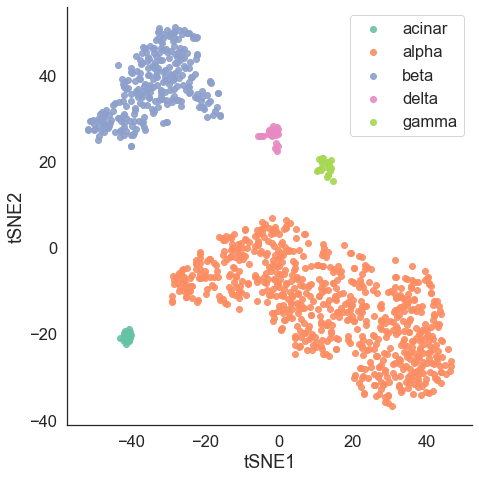

In [12]:
sns.set(font_scale=1.5)
pos_tsne = pd.read_csv(analysis_folder+'tsne_coord.csv', sep='\t',index_col=0)
df_tsne = pd.concat([pos_tsne, filtered_dataset.samplesheet['cell_type']],axis=1).dropna().sort_values(by='cell_type')

sns.set_style("white")
soft_palette = sns.color_palette(['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854'])
fig = sns.lmplot( x="tSNE1", y="tSNE2", data=df_tsne, fit_reg=False, hue='cell_type' , legend=False,
           palette=soft_palette,scatter_kws={'alpha':0.9},size=7,)
plt.legend(loc='upper right')
plt.tight_layout(h_pad=0.01)
fig.savefig(fig_folder+'/fig1a.pdf', dpi=300)


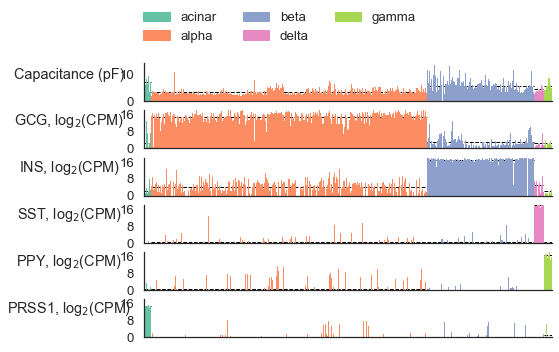

In [13]:
sns.set(font_scale=1.2)
sns.set_style("white")
genes = ['GCG', 'INS', 'SST', 'PPY', 'PRSS1']#,'KRT19']
fig, axs = plt.subplots(nrows=7, ncols=1, figsize = (8,5))

#make plot of gene expression in axes 1,6
axs = axs.flatten()


for i, gene in enumerate(genes):
    x = ds_norm.counts.T.loc[df_sort.index, genes]
    #plot average line
    lines_mean = pd.concat([x, pd.DataFrame(df_sort['cell_type'])],axis=1).groupby('cell_type')[gene].agg(['mean','count'])
    cell_tot = lines_mean['count'].sum()
    cell_pos = 0
    palette_darker = dark_palette
    for j,celltype in enumerate(lines_mean.index): 
        y_h = lines_mean.loc[celltype,'mean']
        x_cells = lines_mean.loc[celltype,'count']
        axs[i+2].axhline(y=y_h, xmin=cell_pos/cell_tot, xmax=(cell_pos + x_cells)/cell_tot,  color='black',linestyle='dashed',linewidth=1,zorder=1)
        cell_pos += x_cells
    
    #plot results
    axs[i+2] = x.plot.bar(y=genes[i], ax=axs[i+2], legend=False, color = df_palette, width=1.1, linewidth=0 ,zorder=2)
    #remove labels and add legend
    axs[i+2].get_xaxis().set_visible(False)
    axs[i+2].set_ylabel(genes[i] + r', log$_{2}$(CPM)', rotation=0, labelpad=50)
    axs[i+2].set_ylim(0,18)
    axs[i+2].set_yticks([0,8,16])
    
#add line with average size per cell type in cell size
lines_mean = df_sort.groupby('cell_type')['Cell size'].agg(['mean','count'])
cell_tot = lines_mean['count'].sum()
cell_pos = 0
palette_darker = dark_palette
for i,celltype in enumerate(lines_mean.index): 
    y_h = lines_mean.loc[celltype,'mean']
    x_cells = lines_mean.loc[celltype,'count']
    axs[1].axhline(y=y_h, xmin=cell_pos/cell_tot, xmax=(cell_pos + x_cells)/cell_tot, color='black',linestyle='dashed',linewidth=1,zorder=1)
    cell_pos += x_cells

#make plot of cell size in ax 0
axs[1] = df_sort.plot.bar(y='Cell size', ax=axs[1], legend=False, color = df_palette, width=1.1, linewidth=0, zorder=2)

#remove labels and add legend
axs[1].get_xaxis().set_visible(False)
axs[1].set_ylabel('Capacitance (pF)', rotation=0, labelpad=50)

#despine
for i, ax in enumerate(axs):
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)

#add legend in initial ax
axs[0].remove()
legend_plot = [mpatches.Patch(color=df_palette_dict[key], label=key) for key in df_palette_dict]
fig.legend(handles=legend_plot, ncol=3, loc=9, frameon=False)
plt.tight_layout(h_pad=0.01)
fig.savefig(fig_folder+'fig_1b.pdf', dpi=300)


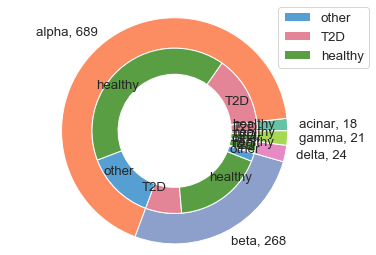

In [14]:
#pick cells to show, sort them and make palette
filter_condition_1 = {
                    'Cryopreserved':['No'],
                   'Patched': ['Yes'],
                    'cell_type': ['alpha', 'beta', 'acinar', 'gamma', 'delta'],
                   'preincubation': ['No','Yes']}
g_pie = filter_samplesheet(ds_pclamp, filter_dict= filter_condition_1)
g_pie.samplesheet.groupby(['cell_type','DiabetesStatus'])['DiabetesStatus'].count()
g_pie.samplesheet['DiabetesStatus'].replace({'prediabetic': 'other', 'T2Dreversed': 'other'}, inplace=True)

#define groups for pie plot
celltype_inner_grouped = g_pie.samplesheet.groupby(['cell_type','DiabetesStatus']).count().fillna(0)
inner_labels = celltype_inner_grouped.index.get_level_values('DiabetesStatus').tolist()
inner_counts = celltype_inner_grouped.percent_multimapped.tolist()

celltype_grouped  =  g_pie.samplesheet.groupby(['cell_type']).count().fillna(0)
group_names = celltype_grouped.index.get_level_values('cell_type').tolist()
group_size = celltype_grouped.percent_multimapped.tolist()

# Make plot
group_labels = ["{}, {}".format(group_names, group_size) for group_names, group_size in zip(group_names, group_size)]
subgroup_names= inner_labels
subgroup_size= inner_counts
 
# Create colors
a, b, c, d, e, f= [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges,plt.cm.Purples,plt.cm.Greys]
g2 =sns.color_palette('Set2',5)
g = sns.color_palette("husl", 3,desat=0.7)
gray_color="#95a5a6"
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_labels, 
                  colors=[g2[0], g2[1],g2[2],g2[3],g2[4]] )

plt.setp( mypie, width=0.35, edgecolor='white')
 
# Second Ring (Inside)

mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.35, labels=inner_labels, 
                   labeldistance=0.7, colors=[g[0], g[1],g[0], g[1],g[2],
                                              g[0], g[1], g[2],g[0], g[1], 
                                              g[0], g[1], g[0], g[1] ])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[9:12],labels[9:12],bbox_to_anchor=(0, 0, 1.1, 1.1))
          
plt.setp( mypie2, width=0.3, edgecolor='white')
#plt.legend(mypie2.labels)
plt.margins(0,0)
 
# show it
plt.show()
fig.tight_layout(rect=(0,0,0.8,0.9))
fig.savefig(fig_folder +'fig_1c.pdf',dpi=300)

#### Supp Figs 1 and 2

In [15]:
#pick cells to show, sort them and make palette based on a property
filter_condition = {'Cryopreserved':['No'],
                   'Patched': ['Yes'],
                   'TimefromDispersion_days': [1,2,3,4],
                     'Glucose_mM': [1,5,10],
                   'preincubation': ['No','Yes'],
                    'cell_type': ['alpha', 'beta', 'other', 'acinar', 'gamma', 'delta'],
                   'species': ['human']}
g1 = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)


filter_condition = {'cell_type': ['alpha_mt', 'alpha', 'gamma', 'beta', 'endocrine', 'delta']}
g2 = filter_samplesheet(ds_FACS, filter_dict= filter_condition)

#pick cells to show, sort them and make palette based on a property
filter_condition = {'cell_type': [ 'alpha', 'gamma', 'beta', 'endocrine', 'delta']}

g3 = filter_samplesheet(ds_sand, filter_dict= filter_condition)

filter_condition = {'cell_type': [ 'alpha', 'gamma', 'beta', 'endocrine', 'delta']}
g4 = filter_samplesheet(ds_mart, filter_dict= filter_condition)

g4.samplesheet = g4.samplesheet[g4.samplesheet.age>20]

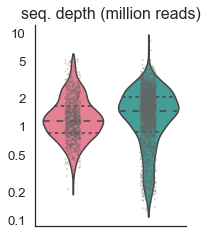

In [16]:
## plot with sequencing depth
groupby_col = 'group'
genes = ['STAR_input_reads']
rename_col = { 'STAR_input_reads': 'seq. depth (million reads)'}

n_par = len(genes)
n_size = 3 * n_par
fig,axs= plt.subplots(nrows=1, ncols=1, figsize=(n_size,3.5),sharey=True)
sns.set_style("whitegrid")

s1 = g1.samplesheet.loc[:,genes].copy()
s1['group'] ='Patch-clamp'
s2 = g2.samplesheet.loc[:,genes].copy()
s2['group'] ='FACS'

plot_test = pd.concat([s1,s2],axis=0)
plot_test = plot_test.rename(columns=rename_col)

plot_test['seq. depth (million reads)'] = np.log10(plot_test['seq. depth (million reads)'])
cols_plot = plot_test.drop(columns='group').columns.tolist()
c = plot_test.melt(id_vars=groupby_col, value_vars=cols_plot,var_name='gene')

for i,gene in enumerate(c.gene.unique()):
    axs = sns.violinplot(x='group', y=gene, data=plot_test, 
                         ax=axs, cut=1, linewidth=1.5,
                         palette='husl',inner='quartile',scale='width')
    axs = sns.stripplot(x='group', y=gene, data=plot_test, 
                        jitter=True, alpha=0.3, ax=axs,color='0.4',s=2)
    axs.set_title(gene,fontsize='16')
    axs.set_ylabel('')
    axs.set_xlabel('')
    axs.set_xticklabels(['',''])
    yticks_locs = list(np.linspace(1e5,1e6, 10))
    yticks_locs.extend(list(np.linspace(1e6,1e7, 10)))
    yticks_names = [''] * 20
    names = {0: '0.1',1:'0.2',4:'0.5',9:'1',11:'2',14:'5',19:'10'}
    for name in names:
        yticks_names[name] = names[name]
    yticks_locs = np.log10(yticks_locs)
    axs.set_yticks(yticks_locs)   
    axs.set_yticklabels(yticks_names)    
    #axs.set_yticklabels(['',''])
sns.despine()
fig.tight_layout()
fig.savefig(fig_folder+'supp_fig1c.pdf')

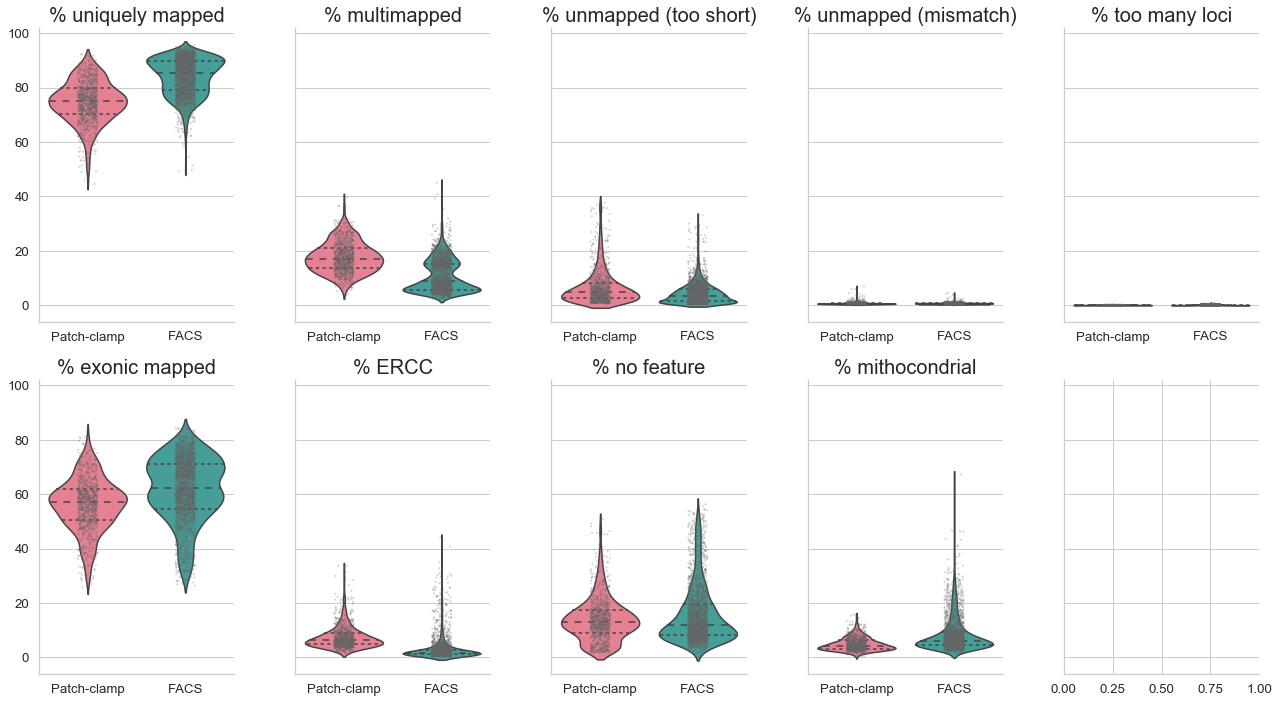

In [17]:
groupby_col = 'group'
genes = [ 'STAR_percent_uniquely_mapped',
         'STAR_percent_multiple_loci',
         'STAR_percent_unmapped_too_short',
         'STAR_percent_unmapped_too_many_mismatches',
         'STAR_percent_too_many_loci','percent_mapped',
         'percent_ercc',
         'percent_nofeature',
         'percent_mito']

rename_col = { 'STAR_percent_uniquely_mapped':'% uniquely mapped',
              'STAR_percent_multiple_loci':'% multimapped',
              'STAR_percent_too_many_loci':'% too many loci',
              'STAR_percent_unmapped_too_many_mismatches':'% unmapped (mismatch)',
              'STAR_percent_unmapped_too_short':'% unmapped (too short)',
              'percent_mapped':'% exonic mapped',
              'percent_nofeature':'% no feature',
              'percent_ercc':'% ERCC',
              'percent_mito': '% mithocondrial'
              }

n_par = len(genes)
n_size = 2 * n_par
fig,axs= plt.subplots(nrows=2, ncols=int(n_par/2)+1, figsize=(n_size,10),sharey=True)
axs=axs.flatten()
sns.set_style("whitegrid")

s1 = g1.samplesheet.loc[:,genes].copy()
s1['group'] ='Patch-clamp'
s2 = g2.samplesheet.loc[:,genes].copy()
s2['group'] ='FACS'

plot_test = pd.concat([s1,s2],axis=0)
plot_test= plot_test.rename(columns=rename_col)
#plot_test_melted = plot_test.melt()

cols_plot = plot_test.drop(columns='group').columns.tolist()
c = plot_test.melt(id_vars=groupby_col, value_vars=cols_plot,var_name='gene')

for i,gene in enumerate(c.gene.unique()):
    axs[i] = sns.violinplot(x='group', y=gene, data=plot_test,  
                            ax=axs[i], cut=1, linewidth=1.5,
                            palette='husl',inner='quartile',scale='width')
    axs[i] = sns.stripplot(x='group', y=gene, data=plot_test, 
                           jitter=True, alpha=0.3, ax=axs[i],color='0.4',s=2)
    axs[i].set_title(gene,fontsize='20')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    #axs[i].set_xticklabels(['',''])

sns.despine()
fig.tight_layout()
fig.savefig(fig_folder+'supp_fig2a.pdf')

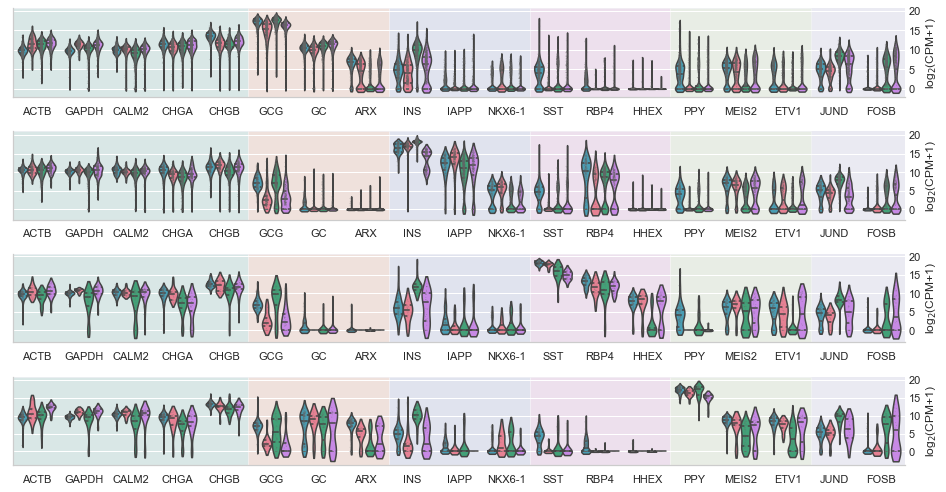

In [18]:
## plot with genes per cell type and group (housekeeping/islet, beta, alpha, pp, sst, ieg)
groupby_col = 'group'
genes=['ACTB','GAPDH','CALM2','CHGA','CHGB','GCG','GC','ARX',
       'INS','IAPP','NKX6-1','SST','RBP4','HHEX','PPY','MEIS2',
       'ETV1', 'JUND','FOSB']
other_col = ['cell_type']
rename_col = { 'cell_type': 'cell type'}
sns.set()
n_par = len(genes)
n_size = 0.7 * n_par
fig,axs= plt.subplots(nrows=4, ncols=1, figsize=(n_size,7),sharey=True)
axs=axs.flatten()
sns.set_style("whitegrid")


filter_cols = other_col
s1 = g1.samplesheet.loc[:, filter_cols].copy()
s1b = g1.counts.loc[genes,:].T.copy()
s1 = pd.concat([s1,s1b],axis=1)
s1['group'] ='Patch-clamp'
s2 = g2.samplesheet.loc[:, filter_cols].copy()
s2b = g2.counts.loc[genes,:].T.copy()
s2 = pd.concat([s2,s2b],axis=1)
s2['group'] ='FACS'
s3 = g3.samplesheet.loc[:, filter_cols].copy()
s3b = g3.counts.loc[genes,:].T.copy()
s3 = pd.concat([s3,s3b],axis=1)
s3['group'] ='Segerstolpe'
s4 = g4.samplesheet.loc[:, filter_cols].copy()
s4b = g4.counts.loc[genes,:].T.copy()
s4 = pd.concat([s4,s4b],axis=1)
s4['group'] ='Enge'

cmap_palette = [
  (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
    (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522)]

plot_test = pd.concat([s3,s1,s2,s4],axis=0)
plot_test= plot_test.rename(columns=rename_col)

plot_test = pd.concat([s3,s1,s2,s4],axis=0)
plot_test = plot_test[plot_test['cell_type'].isin(['alpha','beta','gamma','delta'])]

c = plot_test.melt(id_vars=['cell_type','group'], value_vars=genes, var_name='gene',value_name='log2(CPM)')
colors_palette = sns.color_palette('Paired',8)

for i,cell_type in enumerate(['alpha','beta','delta','gamma']):
    data = c[c.cell_type == cell_type]
    axs[i].set_yticks([])
    axs[i].xaxis.grid(None)
    axs[i] = axs[i].twinx()
    axs[i].axvspan(-1, 4.5, facecolor='#b3e2cd', alpha=0.3, zorder=0)
    axs[i].axvspan(4.5, 7.5, facecolor='#fdcdac', alpha=0.3, zorder=0)
    axs[i].axvspan(7.5, 10.5, facecolor='#cbd5e8', alpha=0.3, zorder=0)
    axs[i].axvspan(10.5, 13.5, facecolor='#f4cae4', alpha=0.3, zorder=0)
    axs[i].axvspan(13.5, 16.5, facecolor='#e6f5c9', alpha=0.3, zorder=0)
    axs[i].axvspan(146.5, 18.5, facecolor='#fff2ae', alpha=0.3, zorder=0)
    axs[i] = sns.violinplot(x='gene', y='log2(CPM)', data=data, hue='group', 
                            ax=axs[i], cut=1, linewidth=1.5, palette=cmap_palette,
                            alpha=1,inner='quartile',scale='width')
    axs[i] = sns.stripplot(x='gene', y='log2(CPM)', data=data, hue='group', 
                           jitter=True, alpha=0.3, dodge=True, 
                           ax=axs[i],palette=['0.4','0.4','0.4','0.4'], s=1)
    axs[i].set_yticks([0,5,10,15,20])
    #axs[i].set_title(cell_type,fontsize='10')
    axs[i].tick_params('both', length=0)
    axs[i].set_ylabel(r'log$_2$(CPM+1)')
    axs[i].set_xlabel('')
    axs[i].set_xlabel('')
    axs[i].yaxis.grid(which='major',linewidth=1,color='w')
    axs[i].xaxis.grid(None)
    axs[i].legend().set_visible(False)
    #axs[i].set_xticklabels(['',''])
sns.despine()
fig.tight_layout()
fig.savefig(fig_folder+'supp_fig2c.png',dpi=300)

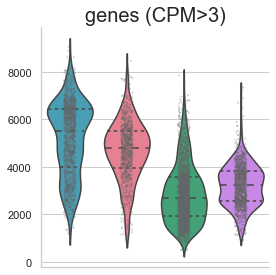

In [19]:
## plot with number of genes
groupby_col = 'group'
genes=['n_genes_3']

rename_col = {
              'n_genes_3': 'genes (CPM>3)'}

n_par = len(genes)
n_size = 4 * n_par
fig,axs= plt.subplots(nrows=1, ncols=int(n_par/2)+1, figsize=(n_size,4),sharey=True)
#axs=axs.flatten()
sns.set_style("whitegrid")

s1 = g1.samplesheet.loc[:,genes].copy()
s1['group'] ='Patch-clamp'
s2 = g2.samplesheet.loc[:,genes].copy()
s2['group'] ='FACS'
s3 = g3.samplesheet.loc[:,genes].copy()
s3['group'] ='Segerstolpe'
s4 = g4.samplesheet.loc[:,genes].copy()
s4['group'] ='Enge'


cmap_palette = [
  (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
    (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522)]
plot_test = pd.concat([s3,s1,s2,s4],axis=0)
plot_test= plot_test.rename(columns=rename_col)

cols_plot = plot_test.drop(columns='group').columns.tolist()
c = plot_test.melt(id_vars=groupby_col, value_vars=cols_plot,var_name='gene')

for i,gene in enumerate(c.gene.unique()):
    axs = sns.violinplot(x='group', y=gene, data=plot_test,  
                         ax=axs, cut=1, linewidth=1.5, palette=cmap_palette,
                         inner='quartile',scale='width')
    axs = sns.stripplot(x='group', y=gene, data=plot_test, 
                        jitter=True, alpha=0.3, ax=axs,color='0.4',s=2)
    axs.set_title(gene,fontsize='20')
    axs.set_ylabel('')
    axs.set_xlabel('')
    axs.set_xticklabels(['',''])
sns.despine()
fig.tight_layout()
fig.savefig(fig_folder+'supp_fig2b.png',dpi=300)

#### Supp Fig 1D-K

In [20]:
filter_condition = { 'cell_type': ['acinar','alpha','beta','delta','gamma','PSCs','ductal'],
                   'Patched': ['Yes'],
                   'Cryopreserved':['No']}

pars = ['Cell size',
        'Total Exocitosis',
        'Late exocytosis',
        'Early exocytosis',
        'Ca2+ entry',
        'Early Ca2+ current',
        'Late Ca2+ current',
        'Peak Na+ current']
#this exports normalized counts for Mann-Whitney

ts = filter_samplesheet(ds_norm_pclamp, filter_dict= filter_condition)
#remove a comma from data
ts.samplesheet[pars] = ts.samplesheet[pars].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))
ts.samplesheet[pars] = ts.samplesheet[pars].astype(float)
groups_rename={'cryo_healthy':'ND cryo','cryo_T1D':'T1D cryo', 'healthy': 'ND'}
ts.samplesheet['DiabetesStatus'].replace(groups_rename, inplace=True)
ts.samplesheet['condition'] = ts.samplesheet['cell_type']+' '+ts.samplesheet['DiabetesStatus']

groupby_col = 'condition'
thres=2

cols = pars + [groupby_col] + ['cell_type']
qlow=0.03
qhigh=0.97

x = filter_quantile_values(ts.samplesheet, 
                           columns=pars, 
                           qlow=qlow,
                           qhigh=qhigh, 
                           include_quantiles=False)

for par in pars:
    if x[par].mean() < 0:
        x[par] = -1*(x[par])
    #clip value of electrophysiology to zero, no negative values
    x[par] = x[par].clip(lower=0)

#mask zero values
x[pars] = x[pars].mask(x[pars]<=0)
#prepare melted dataset
t = x[cols]

t.sort_values(by='condition',inplace=True)

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)
/Users/joan/anaconda/envs/scanpy/lib/python3.

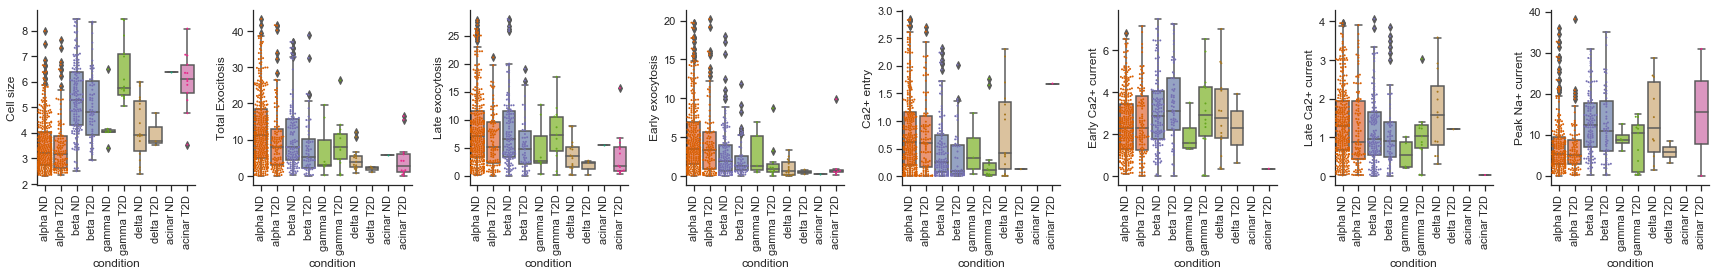

In [21]:
sns.set_style('whitegrid')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig,axs= plt.subplots(nrows=1,ncols=8,figsize=(24,4))
axs = axs.flatten()

new_order = ['alpha', 'beta',  'gamma', 'ductal', 'acinar','PSCs','delta']
order_ct = [ 'alpha ND', 'alpha T2D', 'beta ND', 'beta T2D', 'gamma ND', 'gamma T2D','delta ND', 'delta T2D',
      'acinar ND', 'acinar T2D']

softer_palette = sns.color_palette(['#fdcdac','#fdcdac','#cbd5e8','#cbd5e8','#e6f5c9','#e6f5c9','#f1e2cc','#f1e2cc','#b3e2cd','#f4cae4','#fff2ae'])
dark_palette = sns.color_palette(['#d95f02','#d95f02','#7570b3', '#7570b3', '#66a61e','#66a61e','#a6761d','#a6761d','#1b9e77','#e7298a','#e6ab02'])
soft_palette = sns.color_palette(['#fc8d62','#fc8d62','#8da0cb','#8da0cb', '#a6d854','#a6d854','#e5c494','#e5c494','#66c2a5','#e78ac3','#ffd92f'])


for i,par in enumerate(pars):
    sns.boxplot(y=par, data=t,x='condition',ax=axs[i],palette=soft_palette,order=order_ct)
    sns.swarmplot(y=par, data=t,x='condition',ax=axs[i], palette=dark_palette,size=2,order=order_ct)
    axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
sns.despine()
fig.tight_layout()
fig.savefig(fig_folder + 'SuppFig1_DK.pdf')

In [22]:
from statsmodels.sandbox.stats.multicomp import multipletests
r = {}
for name,group in t.groupby('cell_type'):
    r[name] = df_get_mu_pvals(group, pars=pars, column_class='condition',categories=[name +' ND',name + ' T2D'])

s = pd.concat(r)
s['padj'] = multipletests(pd.concat(r)['pval'], method='fdr_bh')[1]
s.sort_values(by='padj')[['pval','padj']]

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/scipy/stats/stats.py:4911: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


pval      padj
acinar Ca2+ entry          0.000000  0.000000
       Early Ca2+ current  0.000000  0.000000
       Late Ca2+ current   0.000000  0.000000
       Peak Na+ current    0.000000  0.000000
alpha  Total Exocitosis    0.000317  0.002535
gamma  Cell size           0.001600  0.010667
beta   Total Exocitosis    0.002900  0.016573
alpha  Late exocytosis     0.003689  0.018445
beta   Late exocytosis     0.004674  0.020775
       Ca2+ entry          0.017153  0.068610
alpha  Late Ca2+ current   0.030096  0.109439
beta   Cell size           0.036221  0.120737
alpha  Early exocytosis    0.043138  0.132731
delta  Total Exocitosis    0.061767  0.176478
gamma  Early Ca2+ current  0.075641  0.201708
alpha  Cell size           0.100481  0.251203
gamma  Late Ca2+ current   0.117098  0.260218
beta   Early exocytosis    0.112978  0.260218
       Early Ca2+ current  0.131162  0.276131
delta  Late exocytosis     0.143160  0.278956
gamma  Late exocytosis     0.151468  0.278956
       Ca2+ entry          0.153426  0.278956
delta  Peak Na+ current    0.166833  0.290145
acinar Early exocytosis    0.191367  0.306710
gamma  Total Exocitosis    0.191694  0.306710
alpha  Ca2+ entry          0.199553  0.307005
beta   Peak Na+ current    0.231492  0.308656
acinar Late exocytosis     0.228375  0.308656
gamma  Early exocytosis    0.231016  0.308656
alpha  Peak Na+ current    0.222106  0.308656
delta  Ca2+ entry          0.256970  0.331575
       Cell size           0.290210  0.362763
acinar Cell size           0.309898  0.375634
delta  Early Ca2+ current  0.345705  0.395092
acinar Total Exocitosis    0.344250  0.395092
alpha  Early Ca2+ current  0.381645  0.424050
beta   Late Ca2+ current   0.398562  0.430878
delta  Early exocytosis    0.411532  0.433191
       Late Ca2+ current   0.446775  0.458230
gamma  Peak Na+ current    0.477426  0.477426

#### Supp Fig 2

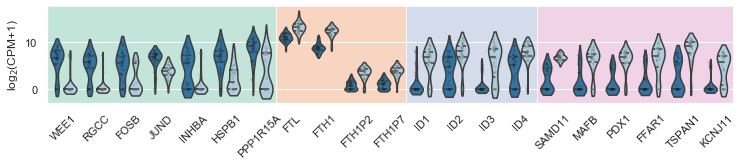

In [23]:
#subselect groups
filter_condition_1 = {'cell_type': ['beta'],
                    'Cryopreserved':['No'],
                   'Patched': ['No'],
                   'TimefromDispersion_days': [0],
                     'Glucose_mM': [5],
                   'preincubation': ['No']}
filter_condition_2 = {'cell_type': ['beta'],
                    'Cryopreserved':['No'],
                   'Patched': ['No'],
                   'TimefromDispersion_days': [1,2,3],
                    'Glucose_mM': [5],
                   'preincubation': ['No']}

#this uexports normalized counts for Mann-Whitney
g1 = filter_samplesheet(ds_pclamp, filter_dict= filter_condition_1)
g2 = filter_samplesheet(ds_pclamp, filter_dict= filter_condition_2)
#add column for each group
g1.samplesheet['group'] ='group1'
g2.samplesheet['group'] ='group2'

## plot with genes per cell type and group (housekeeping/islet, beta, alpha, pp, sst, ieg)
groupby_col = 'group'
genes=['WEE1','RGCC','FOSB','JUND','INHBA','HSPB1','PPP1R15A',
              'FTL','FTH1','FTH1P2','FTH1P7',
        'ID1','ID2','ID3','ID4',
        'SAMD11','MAFB','PDX1','FFAR1','TSPAN1','KCNJ11']


other_col = ['cell_type']
rename_col = { 'cell_type': 'cell type'}
sns.set()
n_par = len(genes)
n_size = 0.5 * n_par
fig,axs= plt.subplots(nrows=2, ncols=1, figsize=(n_size,4),sharey=True)
axs=axs.flatten()
sns.set_style("whitegrid")


filter_cols = other_col
s1 = g1.samplesheet.loc[:, filter_cols].copy()
s1b = g1.counts.loc[genes,:].T.copy()
s1 = pd.concat([s1,s1b],axis=1)
s1['group'] ='day 0'
s2 = g2.samplesheet.loc[:, filter_cols].copy()
s2b = g2.counts.loc[genes,:].T.copy()
s2 = pd.concat([s2,s2b],axis=1)
s2['group'] ='other'


plot_test = pd.concat([s1,s2],axis=0)
plot_test= plot_test.rename(columns=rename_col)

plot_test = pd.concat([s1,s2],axis=0)
plot_test = plot_test[plot_test['cell_type'].isin(['alpha','beta','gamma','delta'])]
sns.set(font_scale=1)
c = plot_test.melt(id_vars=['cell_type','group'], value_vars=genes, 
                   var_name='gene',value_name='log2(CPM)')

for i,cell_type in enumerate(c.cell_type.unique()):
    data = c[c.cell_type == cell_type]
    axs[i].axvspan(-1, 6.5, facecolor='#b3e2cd', alpha=0.7, zorder=0)
    axs[i].axvspan(6.5, 10.5, facecolor='#fdcdac', alpha=0.7, zorder=0)
    axs[i].axvspan(10.5, 14.5, facecolor='#cbd5e8', alpha=0.7, zorder=0)
    axs[i].axvspan(14.5, 20.5, facecolor='#f4cae4', alpha=0.7, zorder=0)
    axs[i] = sns.violinplot(x='gene', y='log2(CPM)', data=data, hue='group', 
                            ax=axs[i], cut=1, linewidth=1.5, palette=sns.color_palette('Paired',2)[::-1],
                            alpha=1,inner='quartile',scale='width')
    axs[i] = sns.stripplot(x='gene', y='log2(CPM)', data=data, hue='group', 
                           jitter=True, alpha=0.3, dodge=True, ax=axs[i],color='0.4',s=2)
    #axs[i].set_title(cell_type,fontsize='10')
    #axs[i].set_xticklabels(genes,fontsize='8')
    axs[i].set_ylabel(r'log$_2$(CPM+1)')
    axs[i].set_xlabel('')
    axs[i].set_xlabel('')
    axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=45)
    axs[i].legend().set_visible(False)
axs[1].remove()
sns.despine()
fig.tight_layout()
fig.savefig(fig_folder + 'SuppFig2G_beta.pdf',dpi=300)

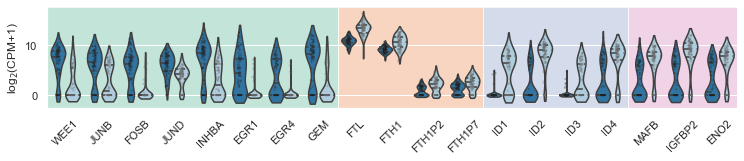

In [24]:
#subselect groups
filter_condition_1 = {'cell_type': ['alpha'],
                    'Cryopreserved':['No'],
                   'Patched': ['No'],
                      'DiabetesStatus':['healthy'],
                   'TimefromDispersion_days': [0],
                     'Glucose_mM': [5],
                   'preincubation': ['No']}
filter_condition_2 = {'cell_type': ['alpha'],
                    'Cryopreserved':['No'],
                   'Patched': ['Yes','No'],
                      'DiabetesStatus':['healthy'],
                   'TimefromDispersion_days': [1,2,3],
                    'Glucose_mM': [5],
                   'preincubation': ['No']}


#this uexports normalized counts for Mann-Whitney
g1 = filter_samplesheet(ds_pclamp, filter_dict= filter_condition_1)
g2 = filter_samplesheet(ds_pclamp, filter_dict= filter_condition_2)
#add column for each group
g1.samplesheet['group'] ='group1'
g2.samplesheet['group'] ='group2'

## plot with genes per cell type and group (housekeeping/islet, beta, alpha, pp, sst, ieg)
groupby_col = 'group'
genes=['WEE1','JUNB','FOSB','JUND','INHBA','EGR1','EGR4','GEM',
       'FTL','FTH1','FTH1P2','FTH1P7',
        'ID1','ID2','ID3','ID4',
        'MAFB','IGFBP2','ENO2']

other_col = ['cell_type']
rename_col = { 'cell_type': 'cell type'}
sns.set()
n_par = len(genes)
n_size = 10.5#0.5 * n_par
fig,axs= plt.subplots(nrows=2, ncols=1, figsize=(n_size,4),sharey=True)
axs=axs.flatten()
sns.set_style("whitegrid")


filter_cols = other_col
s1 = g1.samplesheet.loc[:, filter_cols].copy()
s1b = g1.counts.loc[genes,:].T.copy()
s1 = pd.concat([s1,s1b],axis=1)
s1['group'] ='day 0'
s2 = g2.samplesheet.loc[:, filter_cols].copy()
s2b = g2.counts.loc[genes,:].T.copy()
s2 = pd.concat([s2,s2b],axis=1)
s2['group'] ='other'


plot_test = pd.concat([s1,s2],axis=0)
plot_test= plot_test.rename(columns=rename_col)

plot_test = pd.concat([s1,s2],axis=0)
plot_test = plot_test[plot_test['cell_type'].isin(['alpha','beta','gamma','delta'])]
sns.set(font_scale=1)
c = plot_test.melt(id_vars=['cell_type','group'], value_vars=genes, var_name='gene',value_name='log2(CPM)')
colors_palette = sns.color_palette('Paired',8)

for i,cell_type in enumerate(c.cell_type.unique()):
    data = c[c.cell_type == cell_type]
    axs[i].axvspan(-1, 7.5, facecolor='#b3e2cd', alpha=0.7, zorder=0)
    axs[i].axvspan(7.5, 11.5, facecolor='#fdcdac', alpha=0.7, zorder=0)
    axs[i].axvspan(11.5, 15.5, facecolor='#cbd5e8', alpha=0.7, zorder=0)
    axs[i].axvspan(15.5, 20.5, facecolor='#f4cae4', alpha=0.7, zorder=0)
    axs[i] = sns.violinplot(x='gene', y='log2(CPM)', data=data, hue='group', 
                            ax=axs[i], cut=1, linewidth=1.5, palette=sns.color_palette('Paired',2)[::-1],
                            alpha=1,inner='quartile',scale='width')
    axs[i] = sns.stripplot(x='gene', y='log2(CPM)', data=data, 
                           hue='group', jitter=True, alpha=0.3, 
                           dodge=True, ax=axs[i],color='0.4',s=2)
    axs[i].set_ylabel(r'log$_2$(CPM+1)')
    axs[i].set_xlabel('')
    axs[i].set_xlabel('')
    axs[i].legend().set_visible(False)
    axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=45)
axs[1].remove()
sns.despine()
fig.tight_layout()
fig.savefig(fig_folder + 'SuppFig2G_alpha.pdf',dpi=300)

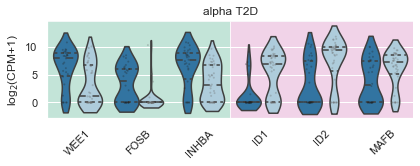

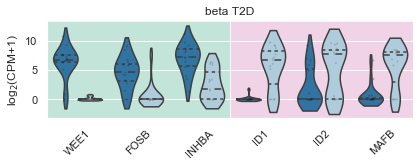

In [25]:
#show recovery also for T2D when using only cells from donors in which we have day 0 cells
cell_types = ['alpha','beta']
for x in cell_types:
    filter_condition_1 = {'cell_type': [x],
                        'Cryopreserved':['No'],
                          'DonorID':['R231',  
                                     'R264',
                                     'R230',
                                     'R229',  
                                     'R256',  
                                     'R260',    
                                     'R234',
                                     'R259'],
                       'Patched': ['No'],
                          'DiabetesStatus':['T2D'],
                       'TimefromDispersion_days': [0]}
    filter_condition_2 = {'cell_type': [x],
                        'Cryopreserved':['No'],
                          'DonorID':['R231',  
                                     'R264',
                                     'R230',
                                     'R229',  
                                     'R256',  
                                     'R260',    
                                     'R234',
                                     'R259'],
                       'Patched': ['Yes','No'],
                          'DiabetesStatus':['T2D'],
                       'TimefromDispersion_days': [1,2,3]}


    #this uexports normalized counts for Mann-Whitney
    g1 = filter_samplesheet(ds_pclamp, filter_dict= filter_condition_1)
    g2 = filter_samplesheet(ds_pclamp, filter_dict= filter_condition_2)
    #add column for each group
    g1.samplesheet['group'] ='group1'
    g2.samplesheet['group'] ='group2'

    ## plot with genes per cell type and group (housekeeping/islet, beta, alpha, pp, sst, ieg)
    groupby_col = 'group'
    genes=['WEE1','FOSB','INHBA',
            'ID1','ID2','MAFB']

    other_col = ['cell_type']
    rename_col = { 'cell_type': 'cell type'}
    sns.set()
    n_par = len(genes)
    n_size = 6#0.5 * n_par
    fig,axs= plt.subplots(nrows=2, ncols=1, figsize=(n_size,4),sharey=True)
    axs=axs.flatten()
    sns.set_style("whitegrid")


    filter_cols = other_col
    s1 = g1.samplesheet.loc[:, filter_cols].copy()
    s1b = g1.counts.loc[genes,:].T.copy()
    s1 = pd.concat([s1,s1b],axis=1)
    s1['group'] ='day 0'
    s2 = g2.samplesheet.loc[:, filter_cols].copy()
    s2b = g2.counts.loc[genes,:].T.copy()
    s2 = pd.concat([s2,s2b],axis=1)
    s2['group'] ='other'


    plot_test = pd.concat([s1,s2],axis=0)
    plot_test= plot_test.rename(columns=rename_col)

    plot_test = pd.concat([s1,s2],axis=0)
    plot_test = plot_test[plot_test['cell_type'].isin(['alpha','beta','gamma','delta'])]
    sns.set(font_scale=1)
    c = plot_test.melt(id_vars=['cell_type','group'], value_vars=genes, 
                       var_name='gene',value_name='log2(CPM)')
    colors_palette = sns.color_palette('Paired',8)

    for i,cell_type in enumerate(c.cell_type.unique()):
        data = c[c.cell_type == cell_type]
        axs[i].axvspan(-1, 2.5, facecolor='#b3e2cd', alpha=0.7, zorder=0)
        axs[i].axvspan(2.5, 7.5, facecolor='#f4cae4', alpha=0.7, zorder=0)
        axs[i] = sns.violinplot(x='gene', y='log2(CPM)', data=data, hue='group', 
                                ax=axs[i], cut=1, linewidth=1.5, palette=sns.color_palette('Paired',2)[::-1],
                                alpha=1,inner='quartile',scale='width')
        axs[i] = sns.stripplot(x='gene', y='log2(CPM)', data=data, 
                               hue='group', jitter=True, alpha=0.3, 
                               dodge=True, ax=axs[i],color='0.4',s=2)
        axs[i].set_ylabel(r'log$_2$(CPM+1)')
        axs[i].set_xlabel('')
        axs[i].set_xlabel('')
        axs[i].set_title(x + ' T2D')
        axs[i].legend().set_visible(False)
        axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=45)
    axs[1].remove()
    sns.despine()
    fig.tight_layout()
    fig.savefig(fig_folder + 'SuppFig2H'+x+'.pdf',dpi=300)

#### Supp Fig 2D

In [26]:
filter_condition = {'cell_type': ['beta','alpha'], 
                    'DiabetesStatus': ['healthy'],
                   'Patched': ['Yes','No'],
                    'TimefromDispersion_days':[1,2,3,4],
                    'preincubation': ['Yes','No']}
filtered_dataset = filter_samplesheet(ds_pclamp_raw, filter_dict= filter_condition)
filtered_dataset.samplesheet['type']= 'pclamp'
filter_condition2 = {'cell_type': ['beta','alpha'], 
                    'DiabetesStatus': ['healthy']}
filtered_dataset2 = filter_samplesheet(ds_FACS_raw, filter_dict= filter_condition2)
filtered_dataset2.samplesheet['type']= 'FACS'


In [27]:
df_bulk_pclamp = make_bulk_raw_sc(filtered_dataset, 
                                  columns_split=['DonorID','cell_type','type'], 
                                  n_min_cells=10)
df_bulk_FACS = make_bulk_raw_sc(filtered_dataset2, 
                                columns_split=['DonorID','cell_type','type'], 
                                n_min_cells=10)

In [28]:
df_bulk_pclamp = make_bulk_raw_sc(filtered_dataset, 
                                  columns_split=['DonorID','cell_type','type'], 
                                  n_min_cells=10)
df_bulk_FACS = make_bulk_raw_sc(filtered_dataset2, 
                                columns_split=['DonorID','cell_type','type'], 
                                n_min_cells=10)

df_bulk_FACS[df_bulk_FACS>1].count(axis=0)
df_bulk_pclamp[df_bulk_pclamp>1].count(axis=0)

R233|alpha|pclamp    12789
R233|beta|pclamp     12713
R234|beta|pclamp     12649
R235|alpha|pclamp    12566
R235|beta|pclamp     13241
R237|alpha|pclamp    14213
R237|beta|pclamp     12355
R238|alpha|pclamp    11149
R239|alpha|pclamp    12709
R239|beta|pclamp     13004
R243|alpha|pclamp    13984
R246|alpha|pclamp    14222
R252|alpha|pclamp    13375
R252|beta|pclamp     12917
R253|alpha|pclamp    14052
R256|alpha|pclamp    15036
R260|alpha|pclamp    14289
R260|beta|pclamp     13344
R264|alpha|pclamp    13965
dtype: int64

In [29]:
import warnings
warnings.filterwarnings('ignore')

df_bulk = pd.concat([df_bulk_FACS,df_bulk_pclamp],axis=1).dropna()
df_bulk_filt = df_bulk[df_bulk.mean(axis=1) >2]
mean, z_score, df2 = get_zscores(df_bulk_filt, num_bin=20)
var_genes2 = z_score.nlargest(500).index.values
df_bulk_filt = df_bulk_filt.loc[var_genes2,:].copy()

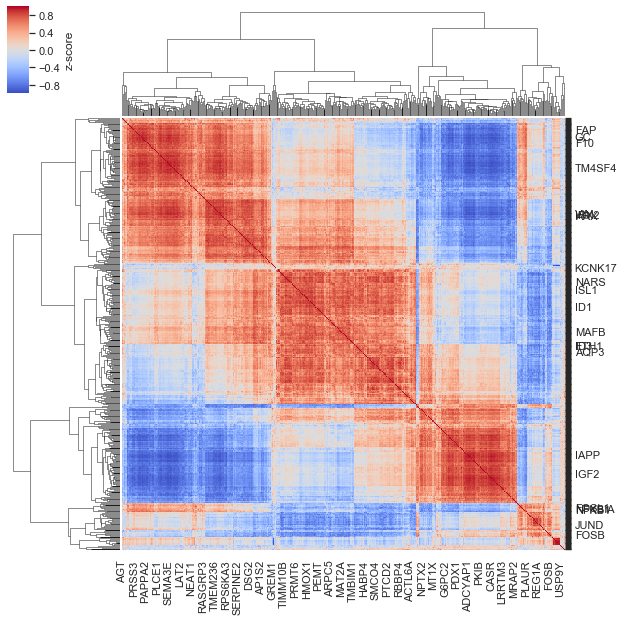

In [30]:
genestokeep = ['GC','F10','ARX','FAP','TM4SF4','VIM','IRX2','FTH1','MAFB',
               'ISL1','KCNK17','NARS','ID3','ID1','AQP3','IAPP','IGF2',
               'NFKBIA','JUND','FOSB','FOSL1','NFKB1','NFKBIA']

ds_plot = df_bulk_filt.T.corr()
r = ds_plot.index.values.copy()
for i,gene in enumerate(r):
    if gene not in genestokeep:
        r[i] = ' '
sns.clustermap(ds_plot, cmap='coolwarm', yticklabels=r, 
               figsize=(10,10), cbar_kws={'label':'z-score'})
plt.savefig(fig_folder+'supp_fig2D_pseudobulk.pdf', dpi=300)

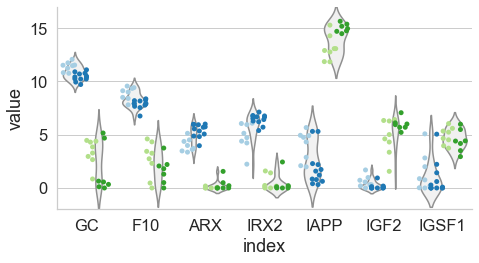

In [31]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
genes= ['GC','F10','ARX','IRX2','IAPP','IGF2','IGSF1']
r =df_bulk.loc[genes].reset_index().melt(id_vars='index')
x =r['variable'].str.split('|', expand=True)
x['combine'] = x[1]+x[2]
r = pd.concat([r,x],axis=1)
x_size = len(genes)*1

fig,ax =plt.subplots(1,1,figsize=(x_size,4))
sns.violinplot(x='index', y='value', hue=1, dodge=True, 
               data=r, ax=ax, inner=None, color='#f0f0f0')
sns.swarmplot(x='index', y='value', hue='combine', dodge=True, 
              palette='Paired', hue_order=['alphaFACS','alphapclamp','betaFACS','betapclamp'], 
              data=r, ax=ax)
ax.set_ylim(-2,17)
ax.legend_.remove()
sns.despine()
fig.tight_layout()
fig.savefig(fig_folder+'supp_fig2E_pseudobulk_celltypegenes.pdf', dpi=300)

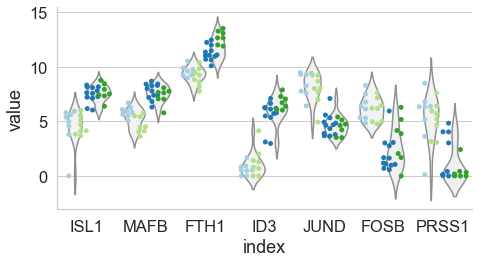

In [32]:
genes= ['ISL1','MAFB','FTH1','ID3','JUND','FOSB','PRSS1']
r =df_bulk.loc[genes].reset_index().melt(id_vars='index')
x =r['variable'].str.split('|', expand=True)
x['combine'] = x[1]+x[2]
r = pd.concat([r,x],axis=1)
x_size = len(genes)*1

paired_reorg = [(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
                (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
                (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
                (0.2, 0.6274509803921569, 0.17254901960784313)]
#sns.violinplot(x="day", y="total_bill", data=tips, inner=None)
x_size = len(genes)*1

fig,ax =plt.subplots(1,1,figsize=(x_size,4))
sns.violinplot(x='index', y='value', hue=2, dodge=True, 
               data=r, ax=ax, inner=None, color='#f0f0f0')
sns.swarmplot(x='index', y='value', hue='combine', dodge=True, palette=paired_reorg, 
              hue_order=['alphaFACS','betaFACS','alphapclamp','betapclamp'], data=r, ax=ax)
ax.legend_.remove()
fig.tight_layout()
sns.despine()
fig.savefig(fig_folder+'supp_fig2E_pseudobulk_methodgenes.pdf', dpi=300)

#### Supp Fig 2I

In [33]:
pos_tsne = pd.read_csv(analysis_folder +'tsne_coord_patch_vs_nonpatch.csv',
                      sep='\t',index_col=0)

In [34]:
filter_condition = {'cell_type': ['beta','alpha','gamma','delta'],
                    'Cryopreserved':['No'],
                   'Patched': ['Yes','No'],
                   'TimefromDispersion_days': [1,2,3,4]}
filtered_dataset = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)


In [35]:
filtered_dataset.samplesheet['combined'] = filtered_dataset.samplesheet['cell_type'] + filtered_dataset.samplesheet['Patched'] 

In [36]:
df_tsne = pd.concat([pos_tsne, filtered_dataset.samplesheet['combined']],axis=1).dropna().sort_values(by='combined',)

In [37]:
df_tsne.drop('1001200610_F4', inplace=True)

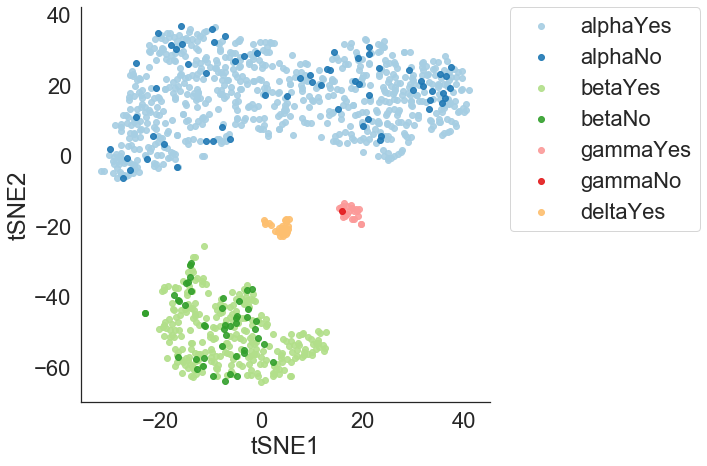

In [38]:
sns.set(font_scale=2)
sns.set_style("white")
soft_palette = sns.color_palette('Paired',7)
order_cat = [ 'alphaYes', 'alphaNo', 'betaYes', 'betaNo',
       'gammaYes', 'gammaNo','deltaYes']
fig = sns.lmplot( x="tSNE1", y="tSNE2", data=df_tsne, 
                 fit_reg=False, hue='combined' , hue_order=order_cat,  legend=False,
                 palette=soft_palette,scatter_kws={'alpha':0.9},height=7,aspect=1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(h_pad=0.01)
fig.savefig(fig_folder+'supp_fig2I.pdf', dpi=300)